# Setup and Imports


In [ ]:
from google.colab import files
uploaded_files = files.upload()

Saving pitches.csv to pitches.csv


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef


pd.set_option('display.max_columns', None)

# Data Preprocessing

In [ ]:
pitch = pd.read_csv('pitches.csv')

In [ ]:
pitch['pitch_type'].value_counts()

In [ ]:
pitch = pitch.dropna(subset=["pitch_type"])
pitch = pitch[pitch.pitch_type != 'EP']
pitch = pitch[pitch.pitch_type != 'FO']
pitch = pitch[pitch.pitch_type != 'AB']
pitch = pitch[pitch.pitch_type != 'FA']
pitch = pitch[pitch.pitch_type != 'UN']
pitch = pitch[pitch.pitch_type != 'SC']
pitch = pitch[pitch.pitch_type != 'PO']
pitch = pitch[pitch.pitch_type != 'IN']
pitch = pitch[pitch.pitch_type != 'KN']
pitch = pitch[pitch.x != 'None']

In [ ]:
pitch = pitch.drop(['code', 'type'], axis=1)

In [ ]:
pitch.tail(5)

In [ ]:
X = pitch.iloc[:10000,[0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19,20,22,23,24,25,26]].values
y = pitch.iloc[:10000,27].values

In [ ]:
y = np.where(y == 'KC', 'CU', y)
y = np.where(y == 'FT', 'SI', y)
y = np.where(y == 'FS', 'CH', y)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model Fitting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
classifier = RandomForestClassifier(criterion = 'gini', n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, max_features= 'auto', max_depth= 70, bootstrap= False, random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


# Model Testing and Visualization

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(matthews_corrcoef(y_test, y_pred))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_train, y_train, cv=50)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
X, y = make_multilabel_classification(random_state=0,n_classes=6)
clf = MultiOutputClassifier(classifier).fit(X, y)
# get a list of n_output containing probability arrays of shape
# (n_samples, n_classes)
y_pred = clf.predict_proba(X)
# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])
roc_auc_score(y, y_pred, average=None)
from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV().fit(X, y)
roc_auc_score(y, clf.decision_function(X), average=None)

In [ ]:
labels = np.unique(y_test)
a =  confusion_matrix(y_test, y_pred, labels=labels)
print(a)

In [ ]:
n = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
np.savetxt('preds.csv', n, delimiter=',',fmt="%s")

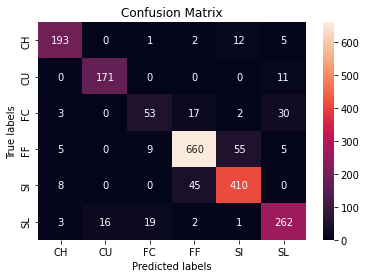

In [ ]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(a, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# Parameter Tuning

In [ ]:
n_estimators = [5,20,50,100,200,300] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')